<a href="https://colab.research.google.com/github/rzagni/Fintech/blob/main/sentiment_nli_zagniA01795457.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**<font color="green">Fintech and Digital Innovation in Finance**</font>
###<font color="green">**Course project part 4 | Advanced RAG techniques & Sentiment Analysis on S&P 500 news**<font>
###<font color="green">**Renzo Zagni A01795457**</font>

# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
%pip install hf_xet
%pip install yfinance

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
#
# Let's hide warnings...
import warnings
warnings.filterwarnings("ignore")



In [4]:
#
# Additional libraries used
import os
from tqdm import tqdm
from scipy.special import softmax

In [5]:
#
# Connect to G Drive to store and retrieve objects
from google.colab import drive
drive.mount('/content/drive')

working_dir = '/content/drive/MyDrive/MNA/Fintech/project4'

os.chdir(working_dir)
print(f"Working directory: {working_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/MNA/Fintech/project4


## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [6]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [7]:
df_meta = pd.read_csv('df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


<font color="green">Note: I will consider the headline as the combination of the title and summary fields.</font>

In [8]:
model = "cross-encoder/nli-deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

positive_hypothesis = "The sentiment of this text is positive"
negative_hypothesis = "The sentiment of this text is negative"



In [9]:
def get_entailment_prob(premise, hypothesis):
    """
    Compute the entailment probability

    Args:
        premise (str): The input text
        hypothesis (str): The hypothesis statement

    Returns:
        float: Probability that the hypothesis is entailed by the premise.
    """
    inputs = tokenizer.encode(premise, hypothesis, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        logits = model(inputs)[0]
    # move logits to CPU before converting to numpy
    probs = softmax(logits.cpu().numpy()[0])
    entailment_prob = probs[2]
    return entailment_prob

In [10]:
positive_probs = []
negative_probs = []

for _, row in tqdm(df_news.iterrows(), total=len(df_news)):
    premise = f"{row['TITLE']} {row['SUMMARY']}"
    pos_prob = get_entailment_prob(premise, positive_hypothesis)
    neg_prob = get_entailment_prob(premise, negative_hypothesis)
    positive_probs.append(pos_prob)
    negative_probs.append(neg_prob)

df_news["POSITIVE_PROB"] = positive_probs
df_news["NEGATIVE_PROB"] = negative_probs
df_news["SENTIMENT"] = df_news["POSITIVE_PROB"] - df_news["NEGATIVE_PROB"]

100%|██████████| 3976/3976 [03:07<00:00, 21.18it/s]


In [11]:
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.997985,0.611628,0.386356
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.998257,0.999095,-0.000838
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.996208,0.046956,0.949253
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.999680,0.998424,0.001256
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.998821,0.998700,0.000121
...,...,...,...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...,0.996984,0.015400,0.981583
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...,0.502373,0.004404,0.497969
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...,0.992205,0.995899,-0.003694
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...,0.942171,0.002314,0.939857


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [12]:
#
# Group the news data by publication date and compute the average sentiment per day
#

#
# Let's get the dates
df_news["DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"]).dt.date

#
# Let's group by date and calculate average sentiment
df_daily_sentiment = df_news.groupby("DATE")["SENTIMENT"].mean().reset_index()

#
# Rename column
df_daily_sentiment.rename(columns={"SENTIMENT": "AVG_SENTIMENT"}, inplace=True)

display(df_daily_sentiment)

,DATE,AVG_SENTIMENT
0,2024-07-12,0.020774
1,2024-07-22,0.001746
2,2024-08-19,0.990258
3,2024-09-13,0.984780
4,2024-10-26,0.643160
...,...,...
113,2025-05-27,0.196769
114,2025-05-28,0.180968
115,2025-05-29,0.201714
116,2025-05-30,0.232413


In [13]:
#
# Download daily stock prices for the relevant tickers using yfinance
#

unique_tickers = df_news["TICKER"].unique().tolist()

#
# Date range from df_daily_sentiments
start_date = df_daily_sentiment["DATE"].min().isoformat()
end_date = df_daily_sentiment["DATE"].max().isoformat()

stock_data = yf.download(
    tickers=unique_tickers,
    start=start_date,
    end=end_date,
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

[*********************100%***********************]  487 of 487 completed


In [14]:
display(stock_data)

Ticker            LRCX                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2024-07-12  104.479780  108.078781  104.037938  105.747986   9459000   
2024-07-15  105.747991  106.943045  105.033331  105.677811   7911000   
2024-07-16  106.321296  106.985550  105.056062  106.357872   6284000   
2024-07-17  100.739436  100.739436   95.603371   95.651802  21142000   
2024-07-18   97.282772   97.282772   92.457088   94.161201  16199000   
...                ...         ...         ...         ...       ...   
2025-05-23   79.921134   81.187978   79.581974   80.858795   8276700   
2025-05-27   82.833884   83.911205   82.105692   83.731651   9530200   
2025-05-28   83.771549   84.818938   83.372541   83.791496   9464100   
2025-05-29   85.636903   86.045889   83.402465   83.951103   8238500   
2025-05-30   83.462311   83.601963   79.292686   80.589462  19191600   

Ticker            DAL                                             ...  \
Price            Open       High        Low      Close    Volume  ...   
Date                                                              ...   
2024-07-12  43.784432  44.198052  42.888259  42.957195  16717000  ...   
2024-07-15  42.947346  42.957193  42.070871  42.346615  12563800  ...   
2024-07-16  42.582968  45.350267  42.504182  45.320724  15554000  ...   
2024-07-17  44.641212  45.330572  44.611665  45.064674   7160500  ...   
2024-07-18  45.054832  46.088877  43.912458  44.237442  10441500  ...   
...               ...        ...        ...        ...       ...  ...   
2025-05-23  46.914872  48.020976  46.715573  47.751923   7811900  ...   
2025-05-27  48.588976  49.954173  48.359783  49.226734  11316100  ...   
2025-05-28  49.097191  49.346314  48.250170  48.429539   7390500  ...   
2025-05-29  48.997539  49.206806  48.030944  48.329891   9060900  ...   
2025-05-30  48.070804  48.539153  47.672206  48.220276   9190700  ...   

Ticker              EA                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2024-07-12  145.148525  146.650757  144.074101  144.929657  2120400   
2024-07-15  144.253174  145.924514  143.069301  144.253174  2116800   
2024-07-16  145.267935  146.710464  144.830199  145.914581  2024300   
2024-07-17  145.914572  147.456592  145.486794  146.242874  2450300   
2024-07-18  146.491571  146.919349  144.651093  145.765335  2415500   
...                ...         ...         ...         ...      ...   
2025-05-23  146.680049  147.738676  146.270591  146.700027  2108700   
2025-05-27  147.349176  147.748668  146.050870  146.720001  4489500   
2025-05-28  146.960007  147.850006  146.389999  146.880005  2280600   
2025-05-29  146.880005  147.100006  141.190002  142.839996  3517100   
2025-05-30  143.190002  144.070007  141.610001  143.779999  5555200   

Ticker             PLD                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2024-07-12  117.868177  118.457519  115.781327  116.080833  4003400  
2024-07-15  116.274070  117.240202  115.114713  117.037315  3264700  
2024-07-16  118.032428  118.032428  116.805443  117.375458  4508600  
2024-07-17  120.225547  124.785695  117.761906  119.037201  8941300  
2024-07-18  118.351247  123.008006  117.945473  118.467186  4631900  
...                ...         ...         ...         ...      ...  
2025-05-23  103.343549  103.868536  102.045930  103.056290  3075500  
2025-05-27  104.393519  105.869429  103.462405  105.611893  4067300  
2025-05-28  105.879337  106.978843  105.473218  106.899597  4580500  
2025-05-29  107.850523  110.326885  107.355251  108.197220  4585600  
2025-05-30  107.682134  108.058538  105.760475  107.573174  726

In [15]:
#
# Convert stock data to regular dataframe
df_close = pd.DataFrame()

for ticker in unique_tickers:
    df_close[ticker] = stock_data[ticker]["Close"]


In [16]:
display(df_close)

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,101.930229,85.815552,101.715202,162.903976,305.015961,559.049988,181.610001,17.660719,90.771393,131.220520,...,155.551407,41.438229,261.168243,230.020004,84.866692,52.492413,136.805130,128.784714,107.694809,176.468231
2024-07-15,100.636986,85.786240,101.018585,162.228165,312.125092,565.710022,179.830002,15.893711,91.486664,130.009842,...,151.893082,41.033291,260.298370,232.470001,83.650505,51.476990,135.698212,125.430489,105.554581,175.423462
2024-07-16,101.215019,89.870369,100.783112,163.357742,319.126251,566.539978,177.550003,16.501411,91.663033,135.021301,...,159.857010,40.830822,261.276978,235.630005,84.985336,52.153942,139.612000,126.440681,106.476067,180.282669
2024-07-17,102.518051,88.072571,102.706154,169.218170,319.715454,563.090027,159.429993,15.790869,92.162735,132.480835,...,147.195160,41.120068,264.390717,231.630005,83.966904,53.498161,137.378372,126.842804,110.033203,179.435028
2024-07-18,101.910622,86.978264,98.183090,165.230774,322.170227,556.849976,155.770004,15.968507,92.388107,130.962540,...,145.910339,41.727467,263.570312,230.580002,82.543068,53.943012,136.429565,125.842407,110.370079,177.075729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,147.619995,66.698288,130.713272,181.690720,308.039368,407.690002,110.309998,9.856293,102.529999,108.301918,...,157.237900,58.499073,308.086334,238.009995,90.470001,69.154556,123.655098,144.740005,92.400391,162.038177
2025-05-27,149.490005,68.240852,132.345932,184.129669,313.860260,413.100006,114.559998,9.935223,103.410004,111.026184,...,166.183060,59.599831,311.705353,239.300003,92.540001,69.233887,125.838120,144.089996,93.966324,165.705902
2025-05-28,148.660004,63.921688,131.430054,181.522171,314.417480,412.230011,112.860001,9.570174,101.989998,110.646980,...,163.872055,60.115505,310.070343,239.899994,90.940002,68.361153,125.250008,143.149994,92.051292,164.848770


In [17]:
#
# Compute daily returns and use their average as a proxy for the market (e.g., S&P 500).
#

df_returns = df_close.pct_change().dropna()

#
# Calculate average
df_returns["MARKET_RETURN"] = df_returns.mean(axis=1)

In [18]:
display(df_returns)

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBH,ZTS,MARKET_RETURN
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-15,-0.012688,-0.000342,-0.006849,-0.004149,0.023307,0.011913,-0.009801,-0.100053,0.007880,-0.009226,...,-0.009772,-0.003331,0.010651,-0.014331,-0.019344,-0.008091,-0.026045,-0.019873,-0.005920,0.001211
2024-07-16,0.005744,0.047608,-0.002331,0.006963,0.022431,0.001467,-0.012679,0.038235,0.001928,0.038547,...,-0.004934,0.003760,0.013593,0.015957,0.013151,0.028842,0.008054,0.008730,0.027700,0.016936
2024-07-17,0.012874,-0.020004,0.019081,0.035875,0.001846,-0.006090,-0.102056,-0.043060,0.005452,-0.018815,...,0.007084,0.011917,-0.016976,-0.011984,0.025774,-0.015999,0.003180,0.033408,-0.004702,-0.004467
2024-07-18,-0.005925,-0.012425,-0.044039,-0.023564,0.007678,-0.011082,-0.022957,0.011249,0.002445,-0.011460,...,0.014771,-0.003103,-0.004533,-0.016957,0.008315,-0.006907,-0.007887,0.003062,-0.013148,-0.008651
2024-07-19,-0.000961,-0.011570,0.019586,0.006895,0.003322,-0.010505,-0.026899,0.001171,-0.014636,-0.001440,...,0.016636,-0.013164,-0.013401,-0.000599,0.002868,-0.003984,-0.010755,-0.007990,-0.003627,-0.005981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,-0.009594,-0.005195,-0.001521,0.003944,-0.021710,-0.016026,-0.003613,0.037383,0.000781,-0.010485,...,0.021472,0.003084,-0.125188,-0.004840,0.007513,-0.009739,-0.000344,0.010582,0.003766,-0.004027
2025-05-27,0.012668,0.023127,0.012490,0.013424,0.018897,0.013270,0.038528,0.008008,0.008583,0.025154,...,0.018817,0.011747,0.005420,0.022881,0.001147,0.017654,-0.004491,0.016947,0.022635,0.018349
2025-05-28,-0.005552,-0.063293,-0.006920,-0.014161,0.001775,-0.002106,-0.014839,-0.036743,-0.013732,-0.003415,...,0.008652,-0.005245,0.002507,-0.017290,-0.012606,-0.004674,-0.006524,-0.020380,-0.005173,-0.008950


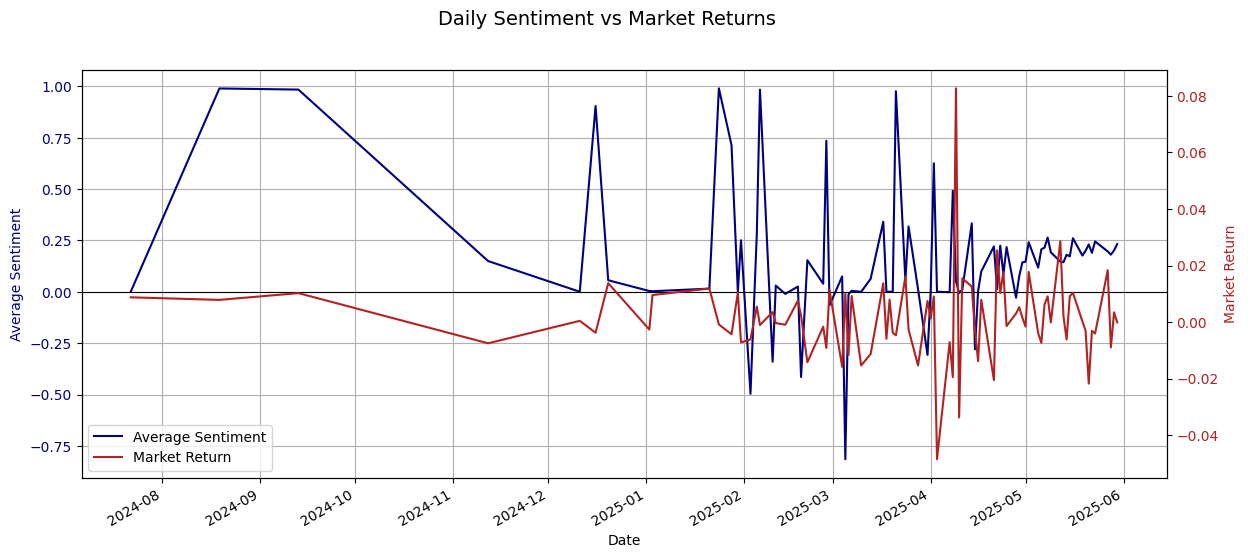

In [19]:
#
# Visualize both daily sentiment and daily returns over time using line plots.
#

df_daily_sentiment["DATE"] = pd.to_datetime(df_daily_sentiment["DATE"])
df_market_proxy = df_returns[["MARKET_RETURN"]].reset_index().rename(columns={"Date": "DATE"})

# Merge both on DATE
df_merged = pd.merge(df_daily_sentiment, df_market_proxy, on="DATE", how="inner")

fig, ax1 = plt.subplots(figsize=(14, 6))

#
# Left y-axis: Sentiment
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="navy")
ax1.plot(df_merged["DATE"], df_merged["AVG_SENTIMENT"], color="navy", label="Average Sentiment")
ax1.tick_params(axis="y", labelcolor="navy")

#
# Right y-axis: Market Returns
ax2 = ax1.twinx()
ax2.set_ylabel("Market Return", color="firebrick")
ax2.plot(df_merged["DATE"], df_merged["MARKET_RETURN"], color="firebrick",  label="Market Return")
ax2.tick_params(axis="y", labelcolor="firebrick")

fig.suptitle("Daily Sentiment vs Market Returns", fontsize=14)
ax1.axhline(0, color="black", linewidth=0.8)
fig.autofmt_xdate()

ax1.grid(True, which="both", axis="both")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower left", fontsize=10)
plt.show()

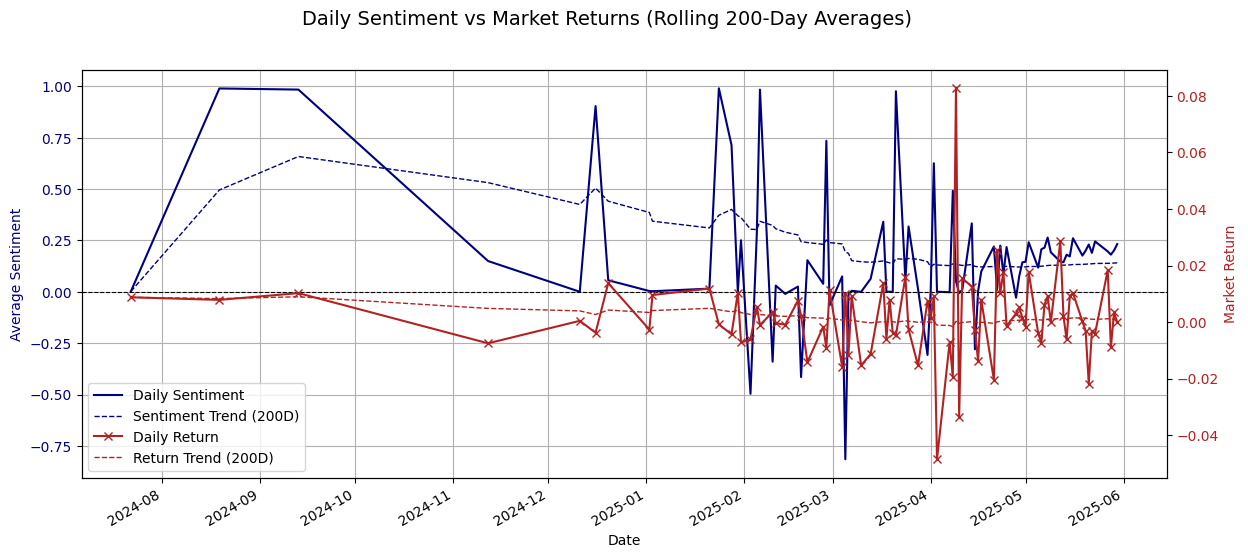

In [20]:
#
# Let's add trendlines to see how the trends correlate
#

#
# No of Days to calculate moving avergate
MA = 200

df = df_merged.copy()
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").set_index("DATE")

#
# Time-based rolling averages (calendar days).
df["SENTIMENT_TREND"] = df["AVG_SENTIMENT"].rolling(f"{MA}D", min_periods=1).mean()
df["MARKET_TREND"]    = df["MARKET_RETURN"].rolling(f"{MA}D", min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: Sentiment
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="navy")
ax1.plot(df.index, df["AVG_SENTIMENT"], color="navy", label="Daily Sentiment")
ax1.plot(df.index, df["SENTIMENT_TREND"], color="navy", linewidth=1, linestyle="--", label=f"Sentiment Trend ({MA}D)")
ax1.tick_params(axis="y", labelcolor="navy")

# Right y-axis: Market Returns
ax2 = ax1.twinx()
ax2.set_ylabel("Market Return", color="firebrick")
ax2.plot(df.index, df["MARKET_RETURN"], color="firebrick", marker="x", label="Daily Return")
ax2.plot(df.index, df["MARKET_TREND"], color="firebrick", linewidth=1, linestyle="--", label=f"Return Trend ({MA}D)")
ax2.tick_params(axis="y", labelcolor="firebrick")

# Title and formatting
fig.suptitle(f"Daily Sentiment vs Market Returns (Rolling {MA}-Day Averages)", fontsize=14)
ax1.axhline(0, color="black", linestyle="--", linewidth=0.8)
fig.autofmt_xdate()

ax1.grid(True, which="both", axis="both")

# Legend (combine both axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left")

plt.show()


## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


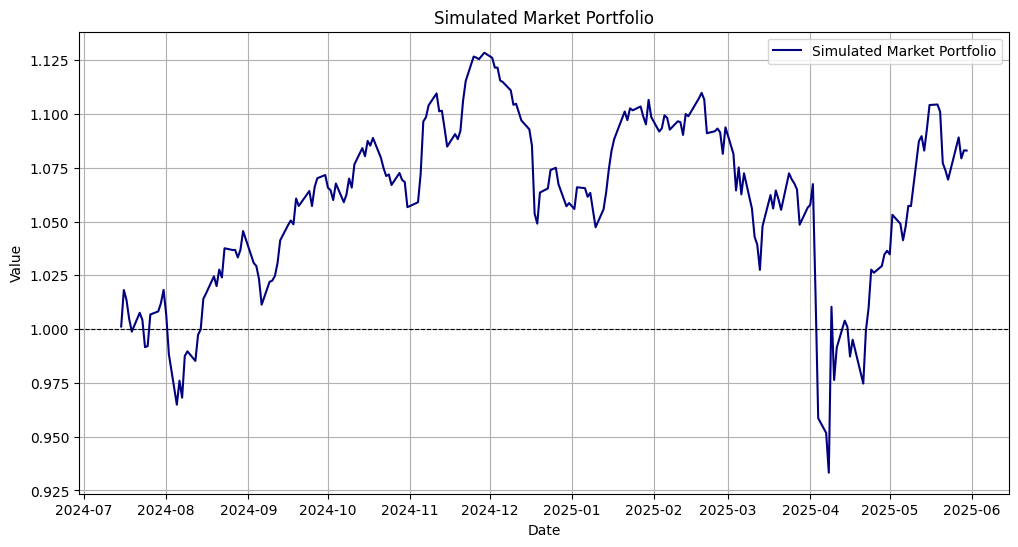

In [21]:
#
# In case we need to rerun the cell, drop old calculations first so we don't
# accumulate values on top of existing ones...
for col in ["MARKET_PORTFOLIO_RETURN", "MARKET_PORTFOLIO_VALUE"]:
    if col in df_returns.columns:
        df_returns = df_returns.drop(columns=[col])

#
# Average daily return of all stocks
df_returns["MARKET_PORTFOLIO_RETURN"] = df_returns.mean(axis=1)

# Calculate cumulative return starting with 1.0
df_returns["MARKET_PORTFOLIO_VALUE"] = (1 + df_returns["MARKET_PORTFOLIO_RETURN"]).cumprod()

# Step 3: Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(df_returns.index, df_returns["MARKET_PORTFOLIO_VALUE"], label="Simulated Market Portfolio", color="navy")
plt.title("Simulated Market Portfolio")
plt.xlabel("Date")
plt.ylabel("Value")
plt.axhline(1.0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid(True)
plt.show()

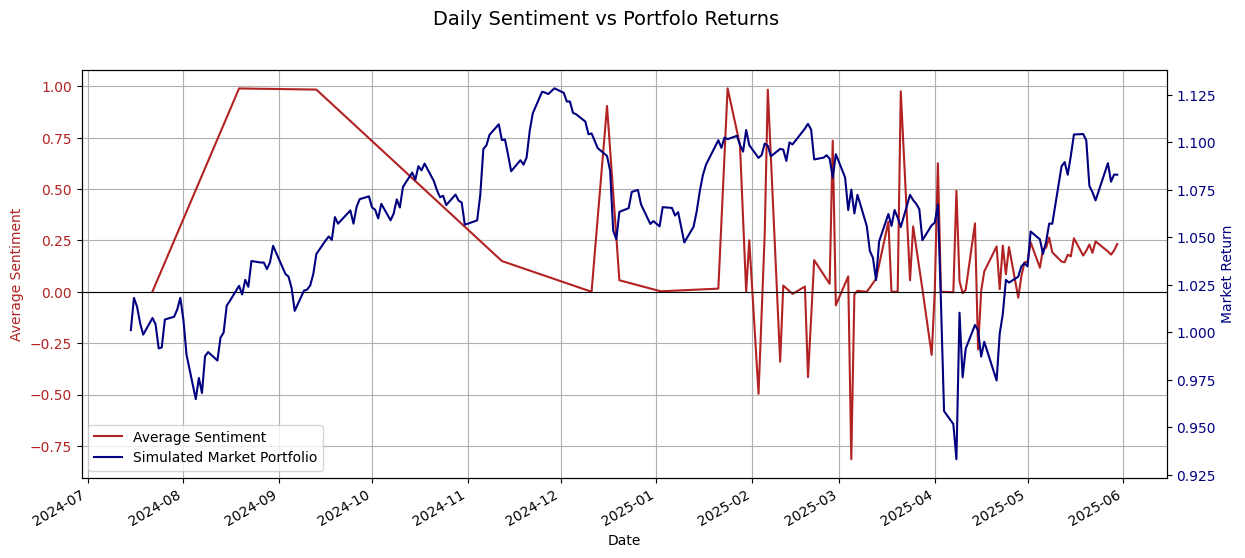

In [22]:
#
# Create a dual y-axis chart to compare trends more effectively.
#
fig, ax1 = plt.subplots(figsize=(14, 6))

#
# Left y-axis: Sentiment
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="firebrick")
ax1.plot(df_merged["DATE"], df_merged["AVG_SENTIMENT"], color="firebrick", label="Average Sentiment")
ax1.tick_params(axis="y", labelcolor="firebrick")

#
# Right y-axis: Market Returns
ax2 = ax1.twinx()
ax2.set_ylabel("Market Return", color="navy")
ax2.plot(df_returns.index, df_returns["MARKET_PORTFOLIO_VALUE"], label="Simulated Market Portfolio", color="navy")
ax2.tick_params(axis="y", labelcolor="navy")

fig.suptitle("Daily Sentiment vs Portfolo Returns", fontsize=14)
ax1.axhline(0, color="black", linewidth=0.8)
fig.autofmt_xdate()


ax1.grid(True, which="both", axis="both")

# Legend (combine both axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left")


plt.show()

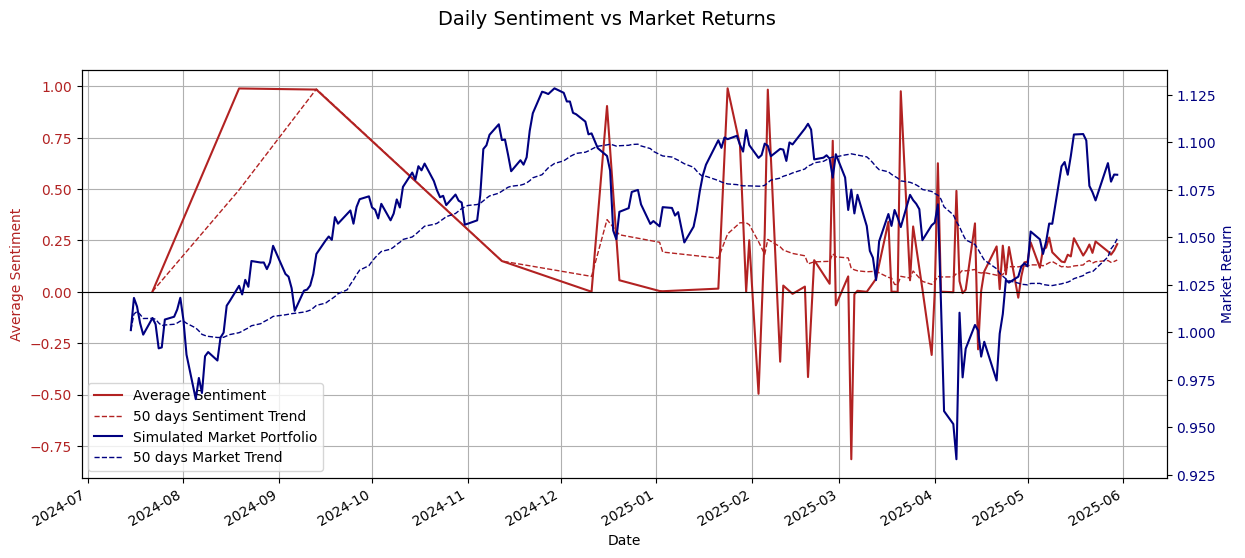

In [23]:
#
# Let's add trendlines to see how the trends correlate
#

MA = 50

df_merged = df_merged.set_index(pd.to_datetime(df_merged["DATE"]))
df_merged["SENTIMENT_TREND"] = (df_merged["AVG_SENTIMENT"].rolling(f"{MA}D", min_periods=1).mean())

df_returns = df_returns.set_index(pd.to_datetime(df_returns.index))
df_returns["MARKET_TREND"] = (df_returns["MARKET_PORTFOLIO_VALUE"].rolling(f"{MA}D", min_periods=1).mean())

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: Sentiment
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="firebrick")
ax1.plot(df_merged["DATE"], df_merged["AVG_SENTIMENT"], color="firebrick",  label="Average Sentiment")
ax1.plot(df_merged["DATE"], df_merged["SENTIMENT_TREND"], color="firebrick", linestyle="--", linewidth=1, label=f"{MA} days Sentiment Trend")
ax1.tick_params(axis="y", labelcolor="firebrick")

# Right y-axis: Market Returns
ax2 = ax1.twinx()
ax2.set_ylabel("Market Return", color="navy")
ax2.plot(df_returns.index, df_returns["MARKET_PORTFOLIO_VALUE"], label="Simulated Market Portfolio", color="navy")
ax2.plot(df_returns.index, df_returns["MARKET_TREND"], color="navy", linestyle="--", linewidth=1, label=f"{MA} days Market Trend")
ax2.tick_params(axis="y", labelcolor="navy")

# Titles and styling
fig.suptitle("Daily Sentiment vs Market Returns", fontsize=14)
ax1.axhline(0, color="black", linewidth=0.8)
fig.autofmt_xdate()
ax1.grid(True, which="both", axis="both")

# Legend (combine both axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left")

plt.show()


## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [24]:
#
# Let's group companies by sector
#
sector_groups = (
    df_meta.groupby("SECTOR")["TICKER"]
    .apply(list)
    .to_dict()
)

for sector, tickers in sector_groups.items():
    print(f"{sector}: {len(tickers)} tickers")

Basic Materials: 19 tickers
Communication Services: 23 tickers
Consumer Cyclical: 55 tickers
Consumer Defensive: 36 tickers
Energy: 21 tickers
Financial Services: 66 tickers
Healthcare: 58 tickers
Industrials: 70 tickers
Real Estate: 31 tickers
Technology: 81 tickers
Utilities: 30 tickers


In [25]:
#
# Compute monthly average sentiment from Feb/25 to May/25
#

df_news["PUBLICATION_DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"], errors="coerce")
df_news = df_news.dropna(subset=["PUBLICATION_DATE"])

#
# Add sector info to each news item
df_news = df_news.merge(df_meta[["TICKER", "SECTOR"]], on="TICKER", how="left")

#
# Retrieve from 01/Feb/25 to 31/May-25
mask = (df_news["PUBLICATION_DATE"] >= "2025-02-01") & \
       (df_news["PUBLICATION_DATE"] <= "2025-05-31")
news_period = df_news.loc[mask].copy()


news_period["month"] = news_period["PUBLICATION_DATE"].dt.to_period("M")

# Calculate sentiment and news counts by sector
sector_monthly_sentiment = (
    news_period.groupby(["SECTOR", "month"])
    .agg(
        avg_sentiment=("SENTIMENT", "mean"),
        headline_count=("SENTIMENT", "count")   # optional
    )
    .reset_index()
)

display(sector_monthly_sentiment)

,SECTOR,month,avg_sentiment,headline_count
0,Basic Materials,2025-02,-0.011174,1
1,Basic Materials,2025-03,0.092585,4
2,Basic Materials,2025-04,0.190054,10
3,Basic Materials,2025-05,0.251791,134
4,Communication Services,2025-03,0.158120,1
5,Communication Services,2025-04,0.009332,5
6,Communication Services,2025-05,0.209979,135
7,Consumer Cyclical,2025-02,-0.415058,3
8,Consumer Cyclical,2025-03,-0.206256,4
9,Consumer Cyclical,2025-04,0.131537,18


In [26]:
#
# Compute monthly stock returns and extract may
#
df_close.index = pd.to_datetime(df_close.index)
monthly_returns = df_close.resample("M").last().pct_change()
may_returns = monthly_returns.loc["2025-05"]
display(may_returns)

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-31,0.073188,-0.052314,0.021644,-0.046079,0.059067,0.106966,0.137442,0.027077,-0.042034,0.040149,...,0.047194,0.033123,0.028427,0.011061,0.130272,-0.008487,0.048706,-0.038513,-0.10558,0.078197


In [27]:
may_returns_long = may_returns.reset_index().melt(
    id_vars="Date", var_name="TICKER", value_name="RETURN"
)

# Attach sector
may_returns_sector = may_returns_long.merge(
    df_meta[["TICKER", "SECTOR"]], on="TICKER", how="left"
)

# Aggregate: sector average return
sector_returns_may = (
    may_returns_sector.groupby("SECTOR")["RETURN"].mean().reset_index()
    .rename(columns={"RETURN": "May_return"})
)


In [28]:
may_sentiment = sector_monthly_sentiment.loc[
    sector_monthly_sentiment["month"] == "2025-05", ["SECTOR", "avg_sentiment"]
].rename(columns={"avg_sentiment": "May_sentiment"})

In [29]:
comparison_table = sector_returns_may.merge(may_sentiment, on="SECTOR", how="inner")

display(comparison_table)

,SECTOR,May_return,May_sentiment
0,Basic Materials,0.029613,0.251791
1,Communication Services,0.041527,0.209979
2,Consumer Cyclical,0.056382,0.156892
3,Consumer Defensive,0.000008,0.143348
4,Energy,0.029434,0.111013
5,Financial Services,0.061068,0.216920
6,Healthcare,0.000100,0.216872
7,Industrials,0.073894,0.204069
8,Real Estate,0.010360,0.285804
9,Technology,0.075271,0.230053


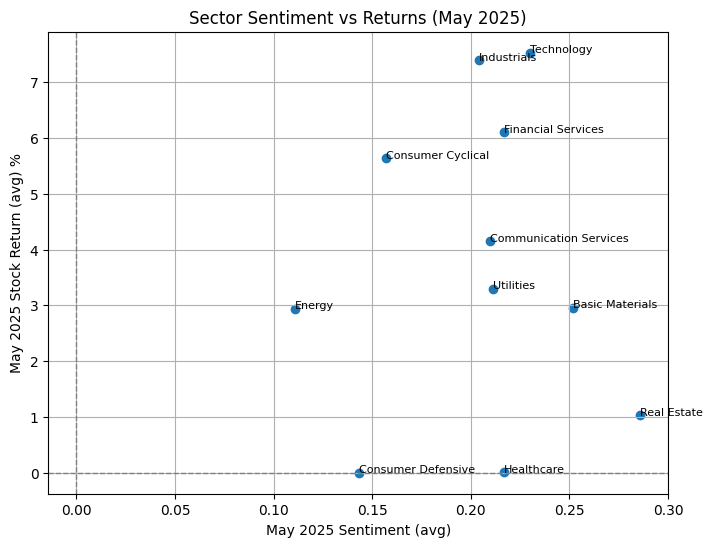

In [30]:
#
# Let's plot the numbers
#
plt.figure(figsize=(8,6))
plt.scatter(
    comparison_table["May_sentiment"],
    comparison_table["May_return"] * 100
)

for _, row in comparison_table.iterrows():
    plt.text(row["May_sentiment"], row["May_return"]* 100, row["SECTOR"], fontsize=8)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("May 2025 Sentiment (avg)")
plt.ylabel("May 2025 Stock Return (avg) %")
plt.title("Sector Sentiment vs Returns (May 2025)")
plt.grid(True)
plt.show()

In [31]:
# Compute correlation
corr = comparison_table["May_sentiment"].corr(comparison_table["May_return"])

print(f"Correlation between May sentiment and May returns: {corr:.4f}")

Correlation between May sentiment and May returns: 0.0250


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


<font color="green">Looking at the numbers , particularly May/2025, we find a few sectors highlighted  in the news. Real Estate received the most positive sentiment of all the sectors, yet this didn’t carry over to the market — it only gained about 1% --one of the bottom 3 sectors. Healthcare and Consumer Defensive had a similar story, positive sentiments but anemic results.

<font color="green">Technology was the clear winner. It got strong positive sentiment and delivered the best returns, up about 7.5%. Financial Services and Industrials also did well on both indicators, with positive sentiments and returns of around 6–7%. Basic Materials looked good in the headlines too and managed a decent 3% return. Utilities got some positive press and ended up with a modest gain as well.

<font color="green">As a recap, the sectors where both sentiment and performance aligned were Technology, Financial Services, Industrials, and Basic Materials. In contrast, Real Estate and Healthcare received favorable coverage, but this did not translate into comparable market returns.

<font color="green">The observations suggest that positive sentiment does not always translate into immediate market gains. In some cases, the market reacts quickly, while in others there is a noticeable delay before sentiment shows up in stock prices, and at times broader economic factors can even override the impact altogether. This means positive news may act more as a leading indicator of potential strength, with the actual performance often emerging later rather than right away.



### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


<font color="green">Two sectors actually performed well even though their sentiment scores were more on the neutral-to-lower side Energy and Consumer Cyclical. Energy, for example, had one of the lowest sentiment levels in May (around 0.11), but still managed a return of about +2.9%. Similarly, Consumer Cyclical didn’t look particularly strong in the news (sentiment ~0.16), yet the sector delivered a solid gain of +5.6%.

<font color="green">This disconnect may comes down to fundamentals and broader market dynamics. For Energy, price action is driven more by oil and gas prices, supply disruptions, or OPEC decisions than by news tone, so gains can occur even when sentiment looks weak. In Consumer Cyclical, spending trends, retail sales, or seasonal demand can provide a lift, especially when supported by strong employment data or resilient consumer confidence. More broadly, sentiment tends to capture short-term tone, while markets often price in longer-term fundamentals or expectations of recovery, which means sectors can rally despite muted or even negative sentiment.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

<font color="green">Investing based on market news sentiment means using the overall tone of financial coverage — whether positive, negative, or neutral — to guide decisions. Sentiment can strongly influence markets: upbeat news often builds confidence and drives buying, while negative stories trigger selling. This makes sentiment useful for spotting early shifts in supply and demand and identifying potential opportunities.

<font color="green">Still, sentiment works best when combined with other analysis. Monitoring general sentiment can help with timing, while strong individual stories may point to short-term trades. But pairing sentiment with fundamentals like earnings and valuations, as well as technical signals, gives a more reliable picture.

<font color="green">There are many tools for tracking sentiment, from news aggregators to AI platforms that scan headlines and social media. Positive earnings surprises, acquisitions, or economic data can quickly shift sentiment and move prices. However, sentiment isn’t foolproof: it can be biased, manipulated, or simply not translate into immediate returns, as seen in some sectors where optimism didn’t match performance.

<font color="green">In short, sentiment is a valuable early signal of potential strength or weakness, but it shouldn’t be used alone. Combined with solid financial and market analysis, it can give investors an edge, but relying on it by itself is risky.


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

<font color="green">For a robuts test a sentiment analysis strategy, the first step is to establish clear rules that can be applied consistently. For example, I might choose to invest in sectors with the highest sentiment scores while avoiding  those with the lowest, or set a rule to buy when sentiment improves sharply relative to the previous month. Once defined, I would backtest these rules on diverse and comprehensive historical data extracted from multiple news sources and across different market cycles. I think it woild also be import to test timing effects, since sentiment may influence prices with a lag, and to compare performance against benchmarks such as market indexes.

<font color="green">Beyond testing rules and backtests, sentiment analysis must be treated as one factor among many rather than a standalone signal. Enhancing the framework with fundamentals, technical indicators, and macroeconomic data creates a more predictive and stable strategy, while experimenting with features like sentiment volatility or momentum can uncover additional insights. At the same time, limitations in financial language — such as sarcasm, noise, or bias — require more advanced fine-tuned large language models to improve accuracy.

<font color="green">Risk controls, such as managing volatility, should be built into the strategy, and evaluation should extend beyond returns to include risk-adjusted measures.

<font color="green">To conclude, because both markets and language nuances evolve, continuous monitoring, robustness checks, and ongoing refinement are very important. Taken together, this kind of rigorous approach may help ensures sentiment strategies are reliable, adaptive, and trully useful for investment decisions.
